<a href="https://colab.research.google.com/github/robertopaulo/CienciaDeDados/blob/main/California.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
# Fazer upload do arquivo housing.csv
arquivo = files.upload()

Saving housing.csv to housing (1).csv


# **Análise exploratória inicial**

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

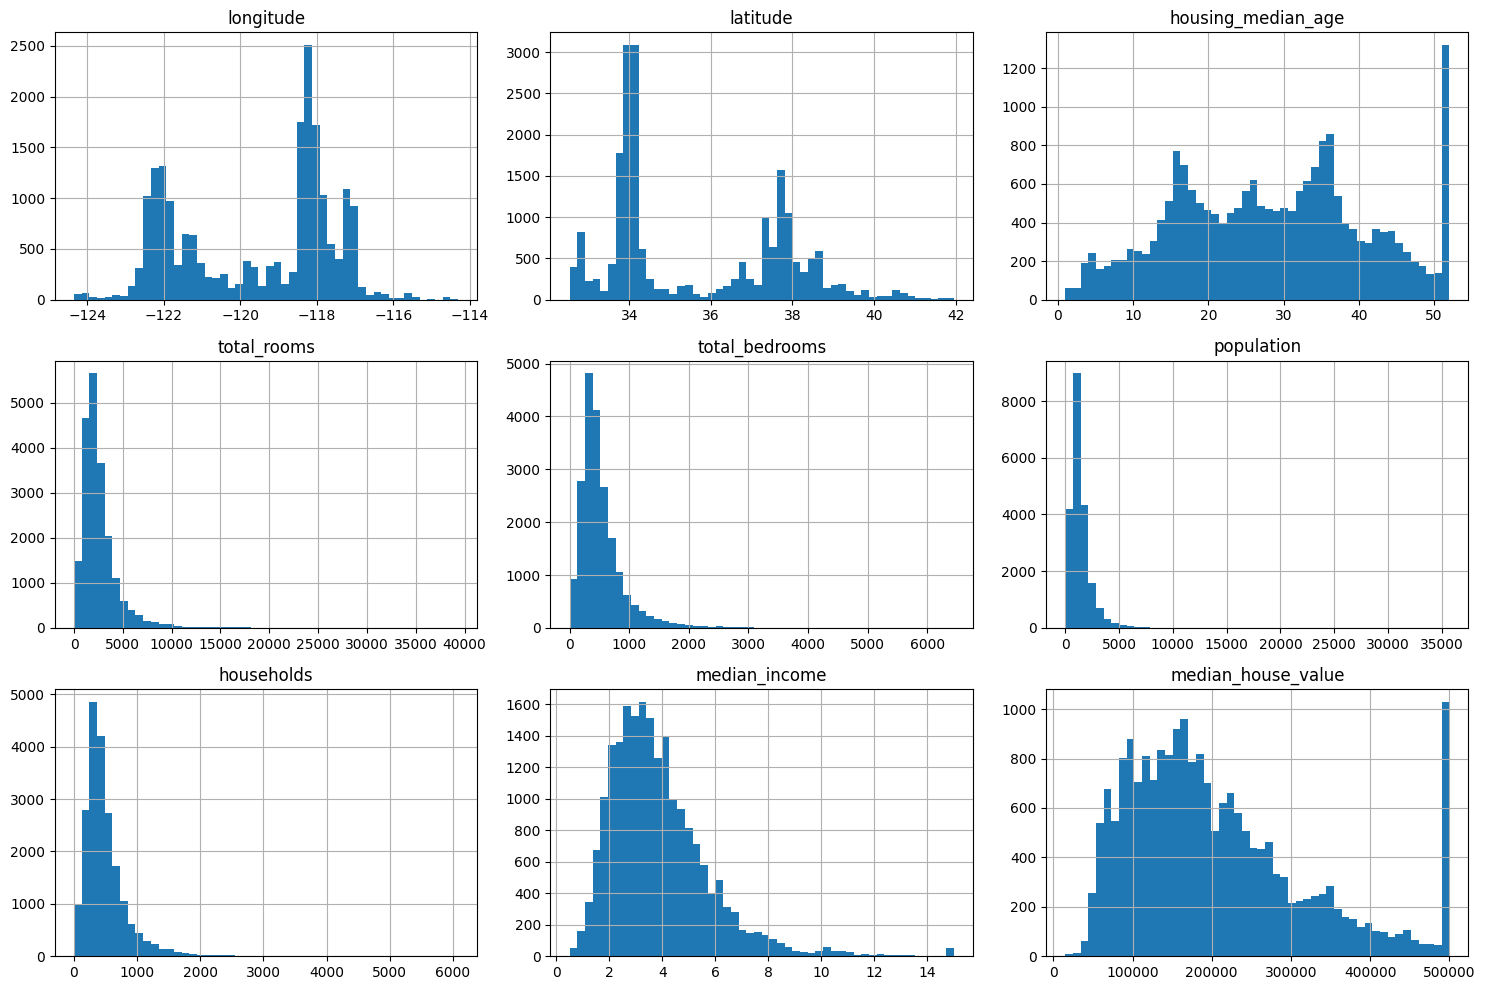

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o dataset
df = pd.read_csv('housing.csv')

# Exibir as 5 primeiras linhas
print(df.head())

# Verificar informações gerais
print(df.info())

# Verificar valores ausentes
print(df.isnull().sum())

# Estatísticas descritivas
print(df.describe())

# Visualizar a distribuição das variáveis numéricas
df.hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()


# **Exploração de Variável Categórica**

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


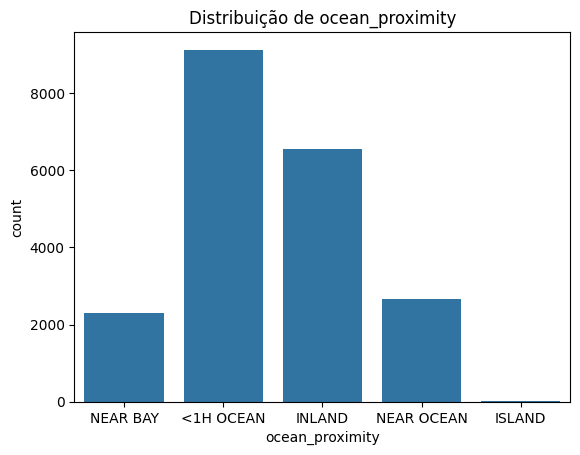

In [ ]:
# Contagem de valores categóricos
print(df['ocean_proximity'].value_counts())
# Visualização da distribuição
sns.countplot(x='ocean_proximity', data=df)
plt.title('Distribuição de ocean_proximity')
plt.show()

# **Análise de Correlações**

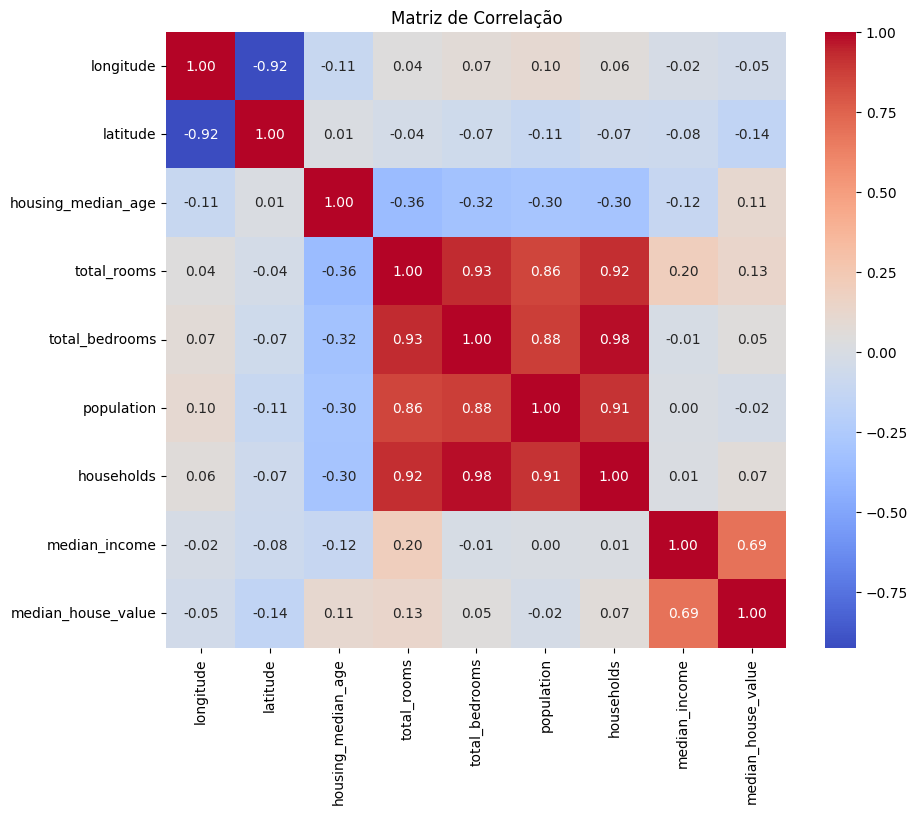

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


In [ ]:
# Matriz de correlação
# Selecionar apenas colunas numéricas (removendo 'ocean_proximity')
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()
# Foco na correlação com a variável-alvo
print(correlation_matrix['median_house_value'].sort_values(ascending=False))

# **Identificação de Outliers**

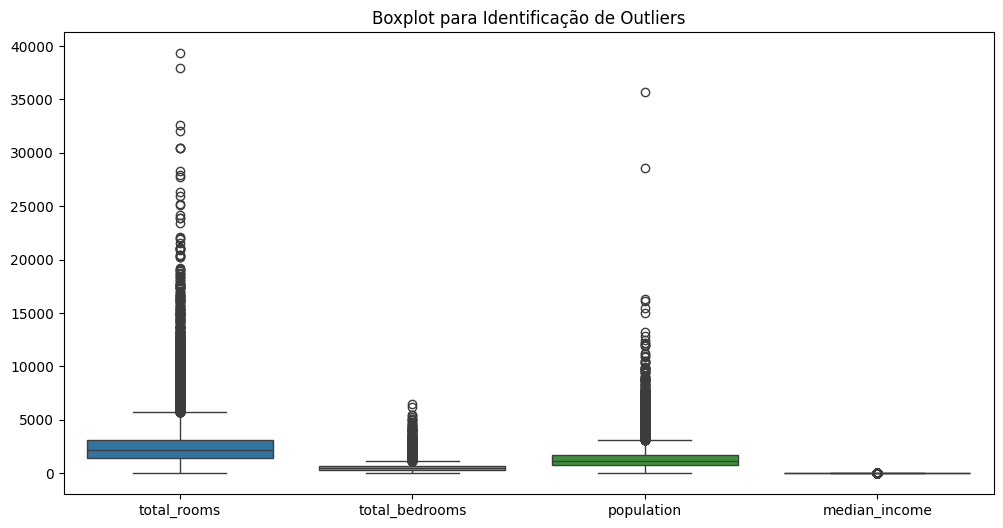

In [ ]:
# Boxplot para variáveis numéricas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['total_rooms', 'total_bedrooms', 'population', 'median_income']])
plt.title('Boxplot para Identificação de Outliers')
plt.show()

# **Análise da Variável-Alvo**

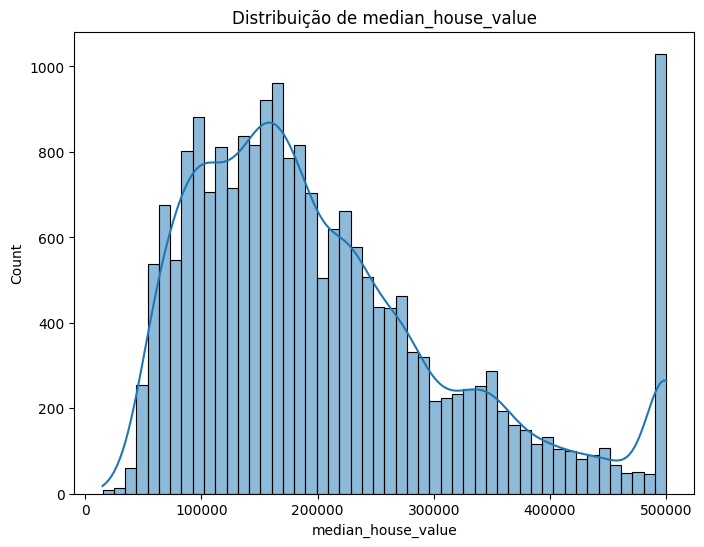

In [ ]:
# Distribuição da variável-alvo
plt.figure(figsize=(8, 6))
sns.histplot(df['median_house_value'], bins=50, kde=True)
plt.title('Distribuição de median_house_value')
plt.show()

# Preparação dos dados para K-means

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Selecionar apenas colunas numéricas (removendo 'ocean_proximity')
numerical_df = df.select_dtypes(include=['float64'])

# Tratar valores ausentes com a média
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(numerical_df)

# Normalizar os dados
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)


# Escolher o número ideal de clusters (método do cotovelo)

In [ ]:
!pip install kneed

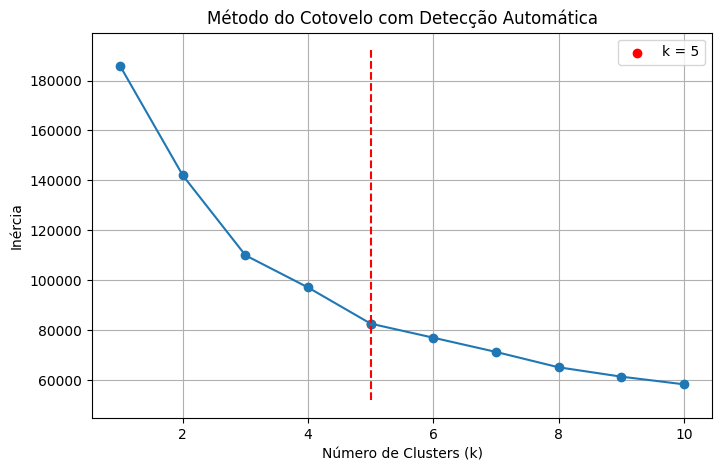

Número ideal de clusters (k): 5


In [ ]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Faixa de valores de k a testar
k_range = range(1, 11)
inertia = []

# Calcular a inércia para cada valor de k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Identificar o cotovelo
knee = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = knee.knee

# Plotar o gráfico com anotação
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.scatter(optimal_k, inertia[optimal_k - 1], color='red', label=f'k = {optimal_k}')
plt.title('Método do Cotovelo com Detecção Automática')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.legend()
plt.grid(True)
plt.show()

print(f'Número ideal de clusters (k): {optimal_k}')


# Aplicação K-means com o número ideal de clusters

In [ ]:
# O cotovelo foi observado em k=5 mas na minha opinião fica melhor com 4
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(data_scaled)

# Adicionar os clusters ao dataframe original
df['Cluster'] = clusters
print(df['Cluster'].value_counts())


Cluster
0    9590
3    7760
1    2978
2     312
Name: count, dtype: int64


# Análise por cluster

In [ ]:
# Perfil médio de cada cluster
cluster_profile = df.groupby('Cluster').mean(numeric_only=True)
print(cluster_profile)

# Ver também a contagem de elementos por cluster
print(df['Cluster'].value_counts())


          longitude   latitude  housing_median_age   total_rooms  \
Cluster                                                            
0       -118.001182  33.905623           30.819917   1945.805944   
1       -119.175772  35.188845           18.956347   5257.548690   
2       -118.881699  35.092692           12.169872  13773.237179   
3       -121.686961  37.956881           30.323067   2034.489820   

         total_bedrooms   population   households  median_income  \
Cluster                                                            
0            407.136158  1150.427007   383.480396       3.894698   
1           1081.980658  2769.311283   995.892545       4.138305   
2           2632.607717  6775.250000  2380.900641       4.409377   
3            405.888108  1034.582216   376.844459       3.716610   

         median_house_value  
Cluster                      
0             213399.916580  
1             224408.945601  
2             214673.426282  
3             191717.901031  
Cl

*   Clusters Geográfico



          longitude   latitude  housing_median_age   total_rooms  \
Cluster                                                            
0       -118.001182  33.905623           30.819917   1945.805944   
1       -119.175772  35.188845           18.956347   5257.548690   
2       -118.881699  35.092692           12.169872  13773.237179   
3       -121.686961  37.956881           30.323067   2034.489820   

         total_bedrooms   population   households  median_income  \
Cluster                                                            
0            407.136158  1150.427007   383.480396       3.894698   
1           1081.980658  2769.311283   995.892545       4.138305   
2           2632.607717  6775.250000  2380.900641       4.409377   
3            405.888108  1034.582216   376.844459       3.716610   

         median_house_value  
Cluster                      
0             213399.916580  
1             224408.945601  
2             214673.426282  
3             191717.901031  


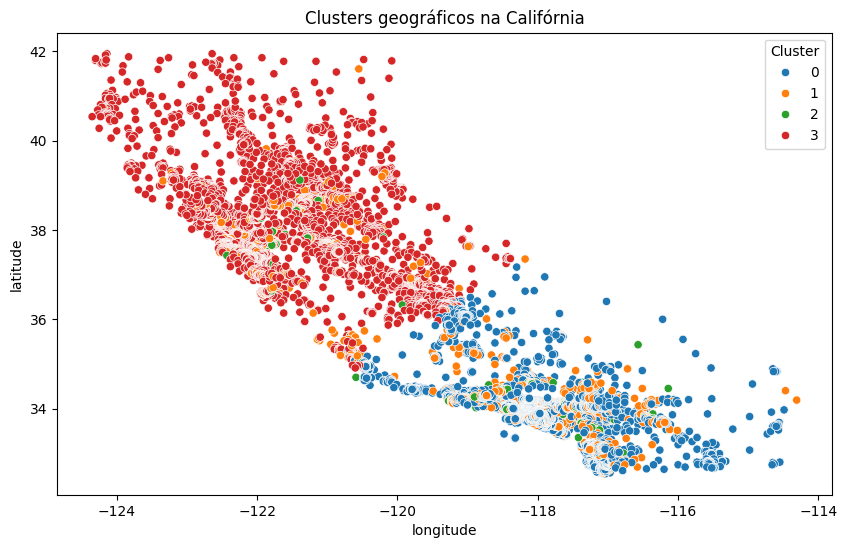

In [ ]:
# Visualização: média das variáveis por cluster
cluster_profile = df.groupby('Cluster').mean(numeric_only=True)
print(cluster_profile)

# Gráfico de dispersão por localização geográfica
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='Cluster', palette='tab10')
plt.title('Clusters geográficos na Califórnia')
plt.show()



*   Distribuição espacial das casas e seus preços

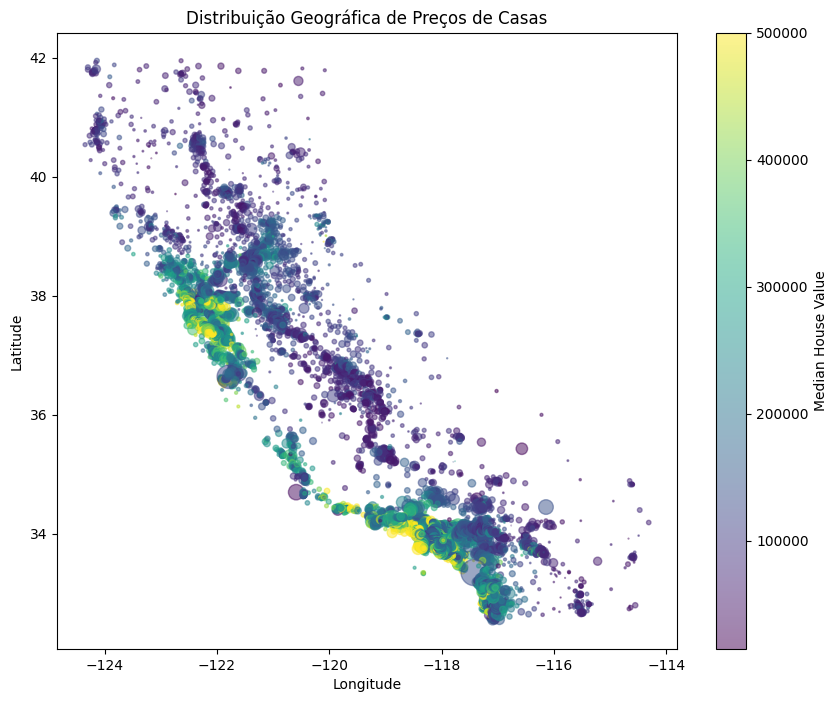

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c=df['median_house_value'], s=df['population']/100,
            cmap='viridis', alpha=0.5)
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribuição Geográfica de Preços de Casas')
plt.show()



*   Preço das Casas por Proximidade ao Oceano




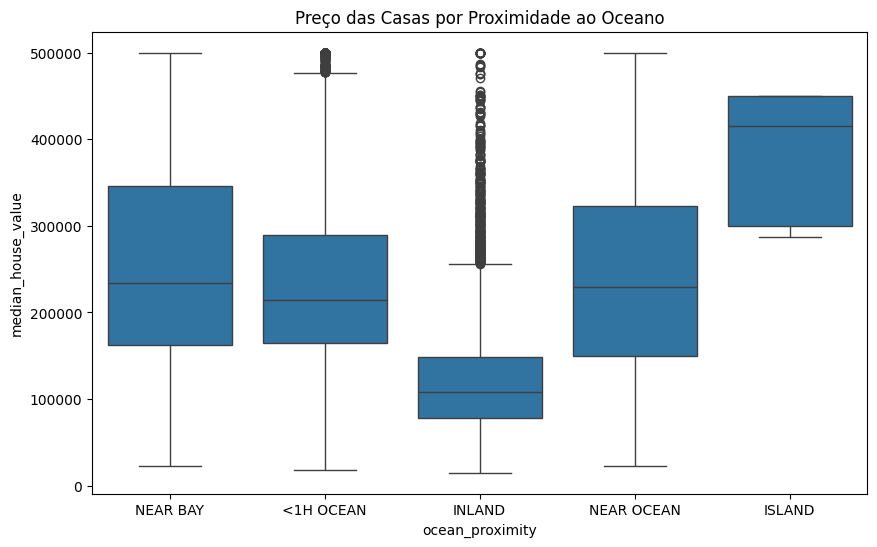

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df)
plt.title('Preço das Casas por Proximidade ao Oceano')
plt.show()

/tmp/ipython-input-49-3473612263.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='median_income', palette='Set2')


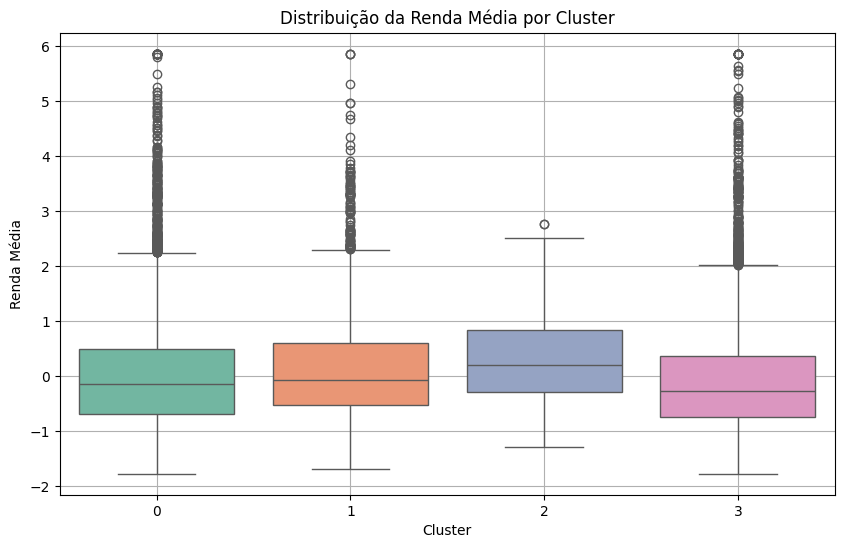

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='median_income', palette='Set2')
plt.title('Distribuição da Renda Média por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Renda Média')
plt.grid(True)
plt.show()


/tmp/ipython-input-48-1501086982.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='housing_median_age', palette='Set3')


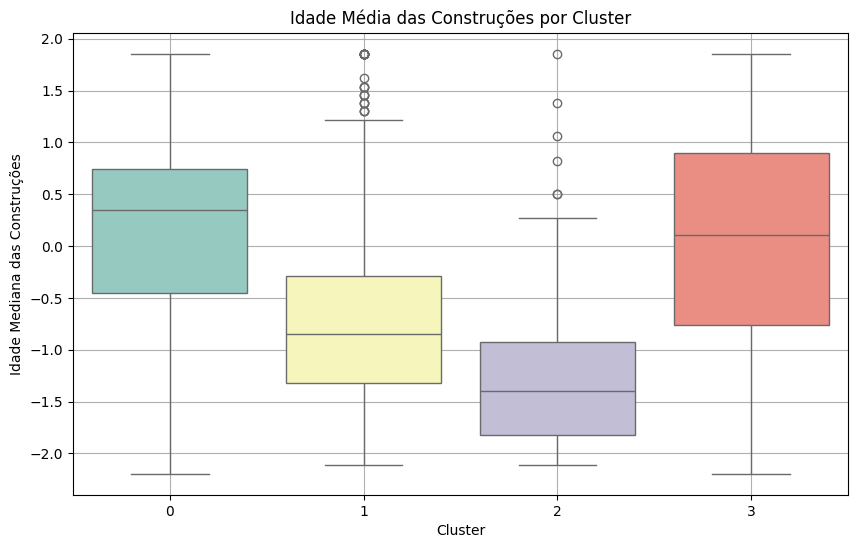

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='housing_median_age', palette='Set3')
plt.title('Idade Média das Construções por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Idade Mediana das Construções')
plt.grid(True)
plt.show()


/tmp/ipython-input-50-4148208235.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='population', palette='pastel')


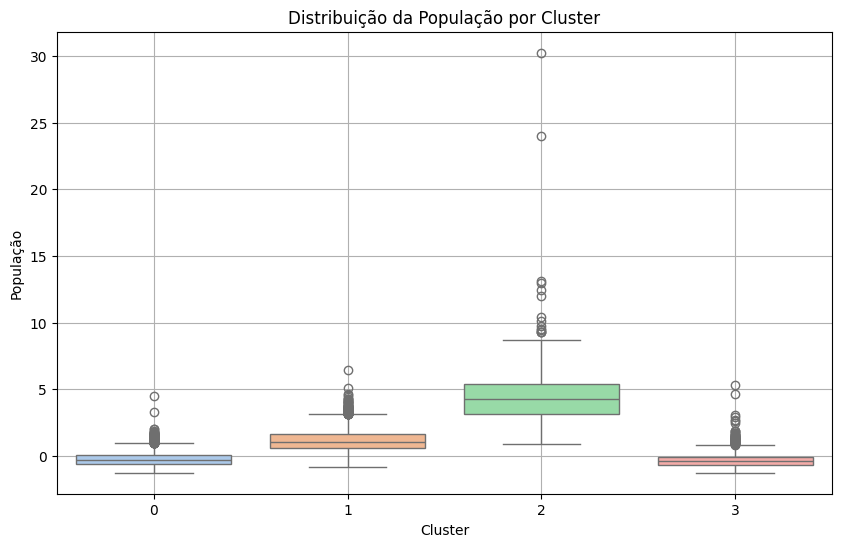

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='population', palette='pastel')
plt.title('Distribuição da População por Cluster')
plt.xlabel('Cluster')
plt.ylabel('População')
plt.grid(True)
plt.show()


/tmp/ipython-input-51-1050187581.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='households', palette='husl')


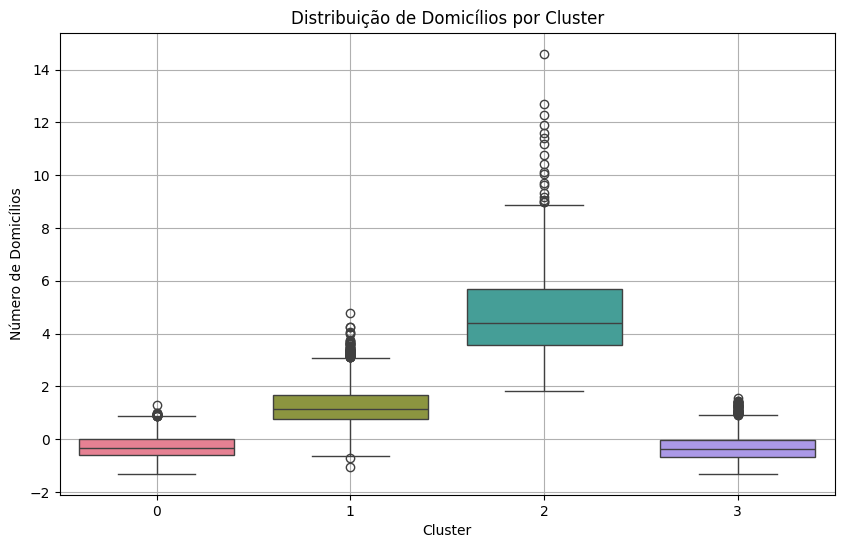

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='households', palette='husl')
plt.title('Distribuição de Domicílios por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Domicílios')
plt.grid(True)
plt.show()


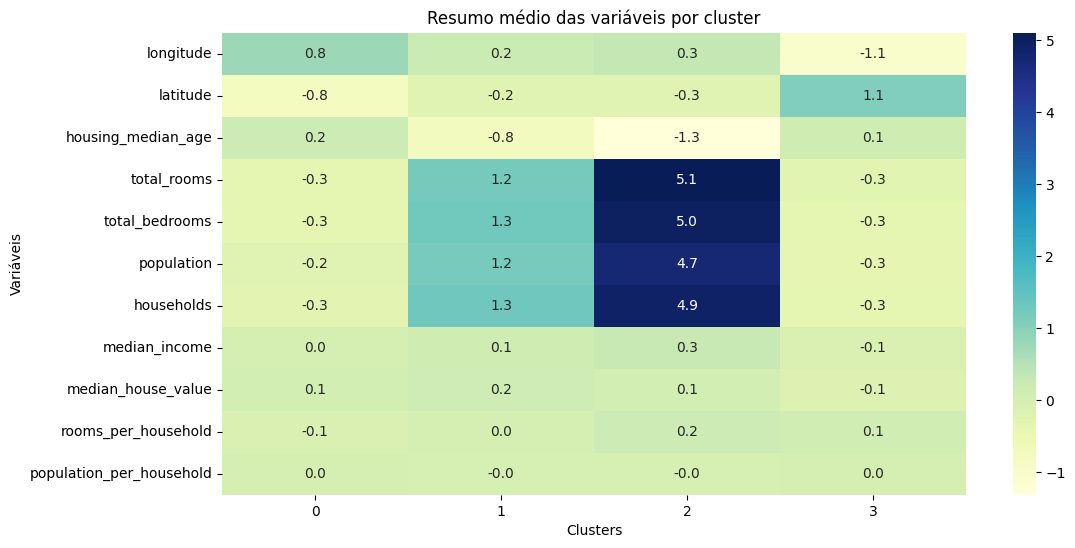

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.groupby('Cluster').mean(numeric_only=True).T, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title("Resumo médio das variáveis por cluster")
plt.ylabel("Variáveis")
plt.xlabel("Clusters")
plt.show()



# **Insights relevantes**

---

*   Cluster 0:

**Localização**: Concentra-se na região sul da Califórnia

**População e Domicílios:** Cluster com a menor densidade demográfica.

**Idade das Construções:** Acima da média, regiões com casas mais antigas.



---


*   Cluster 1

**Localização:** Espalhado

**População e Domicílios:** Levemente acima da média, mas com dispersão, ocupação média.

**Idade das Construções:** Um pouco abaixo da média → construções relativamente novas.



---


*   Cluster 2

**Localização:** Espalhado, Pequenas áreas pontuais

**População e Domicílios:** Alta densidade demográfica, com muitos outliers, áreas densas. e casas muito grandes e com muitas pessoas.

**Idade das Construções:** Bem abaixo da média → regiões novas ou recém-construídas. Casas mais novas da cidade.


---



*   Cluster 3

**Localização:** Grande concentração no norte e centro da Califórnia, longe do litoral.

**População e Domicílios:** Muito baixos, poucas pessoas por casas, casas pequenas.

**Idade das Construções:** Acima da média (relativamente antigas).
